In [1]:
import numpy as np
import numpy.typing as npt
import seaborn as sns
import tifffile as tiff
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import cv2
from scipy.stats import skew
import sys
import numpy.typing as npt


import hdbscan
import umap
import umap.plot


import torch
import torchvision
import gc

In [2]:
%load_ext autoreload
%autoreload 2


import importlib  
au = importlib.import_module("cell-AAP.cell_AAP.annotation.annotation_utils")
sys.path.append('/home/anishjv/cell_seg_classify/notebooks/cell-AAP/cell_AAP/annotation/')
sys.path.append('/home/anishjv/cell_seg_classify/notebooks/cell-AAP/')
ann = importlib.import_module("cell-AAP.cell_AAP.annotation.annotator")
dw = importlib.import_module("cell-AAP.cell_AAP.annotation.dataset_write")
cfg = importlib.import_module("cell-AAP.cell_AAP.configs")

In [3]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor
from segment_anything.modeling import Sam

#Code below should be run if file is not already saved in path 
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

sam_checkpoint = "vit_l.pt"
model_type = "vit_l"
device = 'cuda'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device = device)
predictor = SamPredictor(sam)

In [4]:
import glob 

paths = [
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f0/AB-041122/2025-03-28/20388',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f0-t1/AB-041122/2025-03-29/20391',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f0-t2/AB-041122/2025-03-29/20394',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f1/AB-041122/2025-03-28/20389',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f1-t2/AB-041122/2025-03-29/20396',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f2/AB-041122/2025-03-28/20390',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f2-t1/AB-041122/2025-03-29/20393',
    '/nfs/turbo/umms-ajitj/anishjv/Cell-AAP/raw-data/20250329-cellapp-data/20250328-HT1080RPE1-f2-t2/AB-041122/2025-03-29/20397',
]


fluoro_files = []
phs_files = []
for path in paths:
    fluoro_files += glob.glob(path+'/*Texas Red.tif')
    phs_files += glob.glob(path+'/*phs.tif')
    
    
train_phs_files = sorted([file for file in phs_files if 'A09' not in file])
test_phs_files = sorted([file for file in phs_files if 'A09' in file])

train_fluoro_files = sorted([file for file in fluoro_files if 'A09' not in file])
test_fluoro_files = sorted([file for file in fluoro_files if 'A09' in file])

fluoro_files = train_fluoro_files + test_fluoro_files
phs_files = train_phs_files + test_phs_files


In [5]:
%%time
configs = cfg.Cfg.get_config()
configs.frame_step = 1
configs.iou_thresh = 0.95
configs.box_size = (au.get_box_size, (2,))

def sd_intensity(regionmask, intensity_image):
        return np.std(intensity_image[regionmask])

instance_whole = ann.Annotator.get(configs,fluoro_files,phs_files)

df_whole = instance_whole.crop(predictor = predictor).gen_df(extra_props = (sd_intensity,))

The bounding box side length was 98.82618031575599 pixels
input list: 107
input list: 105
poped indices:2
The bounding box side length was 105.57841966628249 pixels
input list: 75
input list: 73
poped indices:2
The bounding box side length was 106.90679991800482 pixels
input list: 27
input list: 25
poped indices:2
The bounding box side length was 101.12185682903166 pixels
input list: 140
input list: 134
poped indices:9
The bounding box side length was 88.62928130064363 pixels
input list: 290
input list: 274
poped indices:22
The bounding box side length was 96.72689541166224 pixels
input list: 288
input list: 272
poped indices:24
The bounding box side length was 88.05083322490259 pixels
input list: 66
input list: 60
poped indices:9
The bounding box side length was 89.5060853131467 pixels
input list: 68
input list: 64
poped indices:4
The bounding box side length was 89.58723057215225 pixels
input list: 83
input list: 79
poped indices:4
The bounding box side length was 96.65662526453698 p

In [8]:
df_whole.shape
np.save('embeddings/ht1080.npy', df_whole)
np.save('embeddings/ht1080_crops.npy', instance_whole.roi)

In [118]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.3])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='red', facecolor=(0,0,0,0), lw=1))

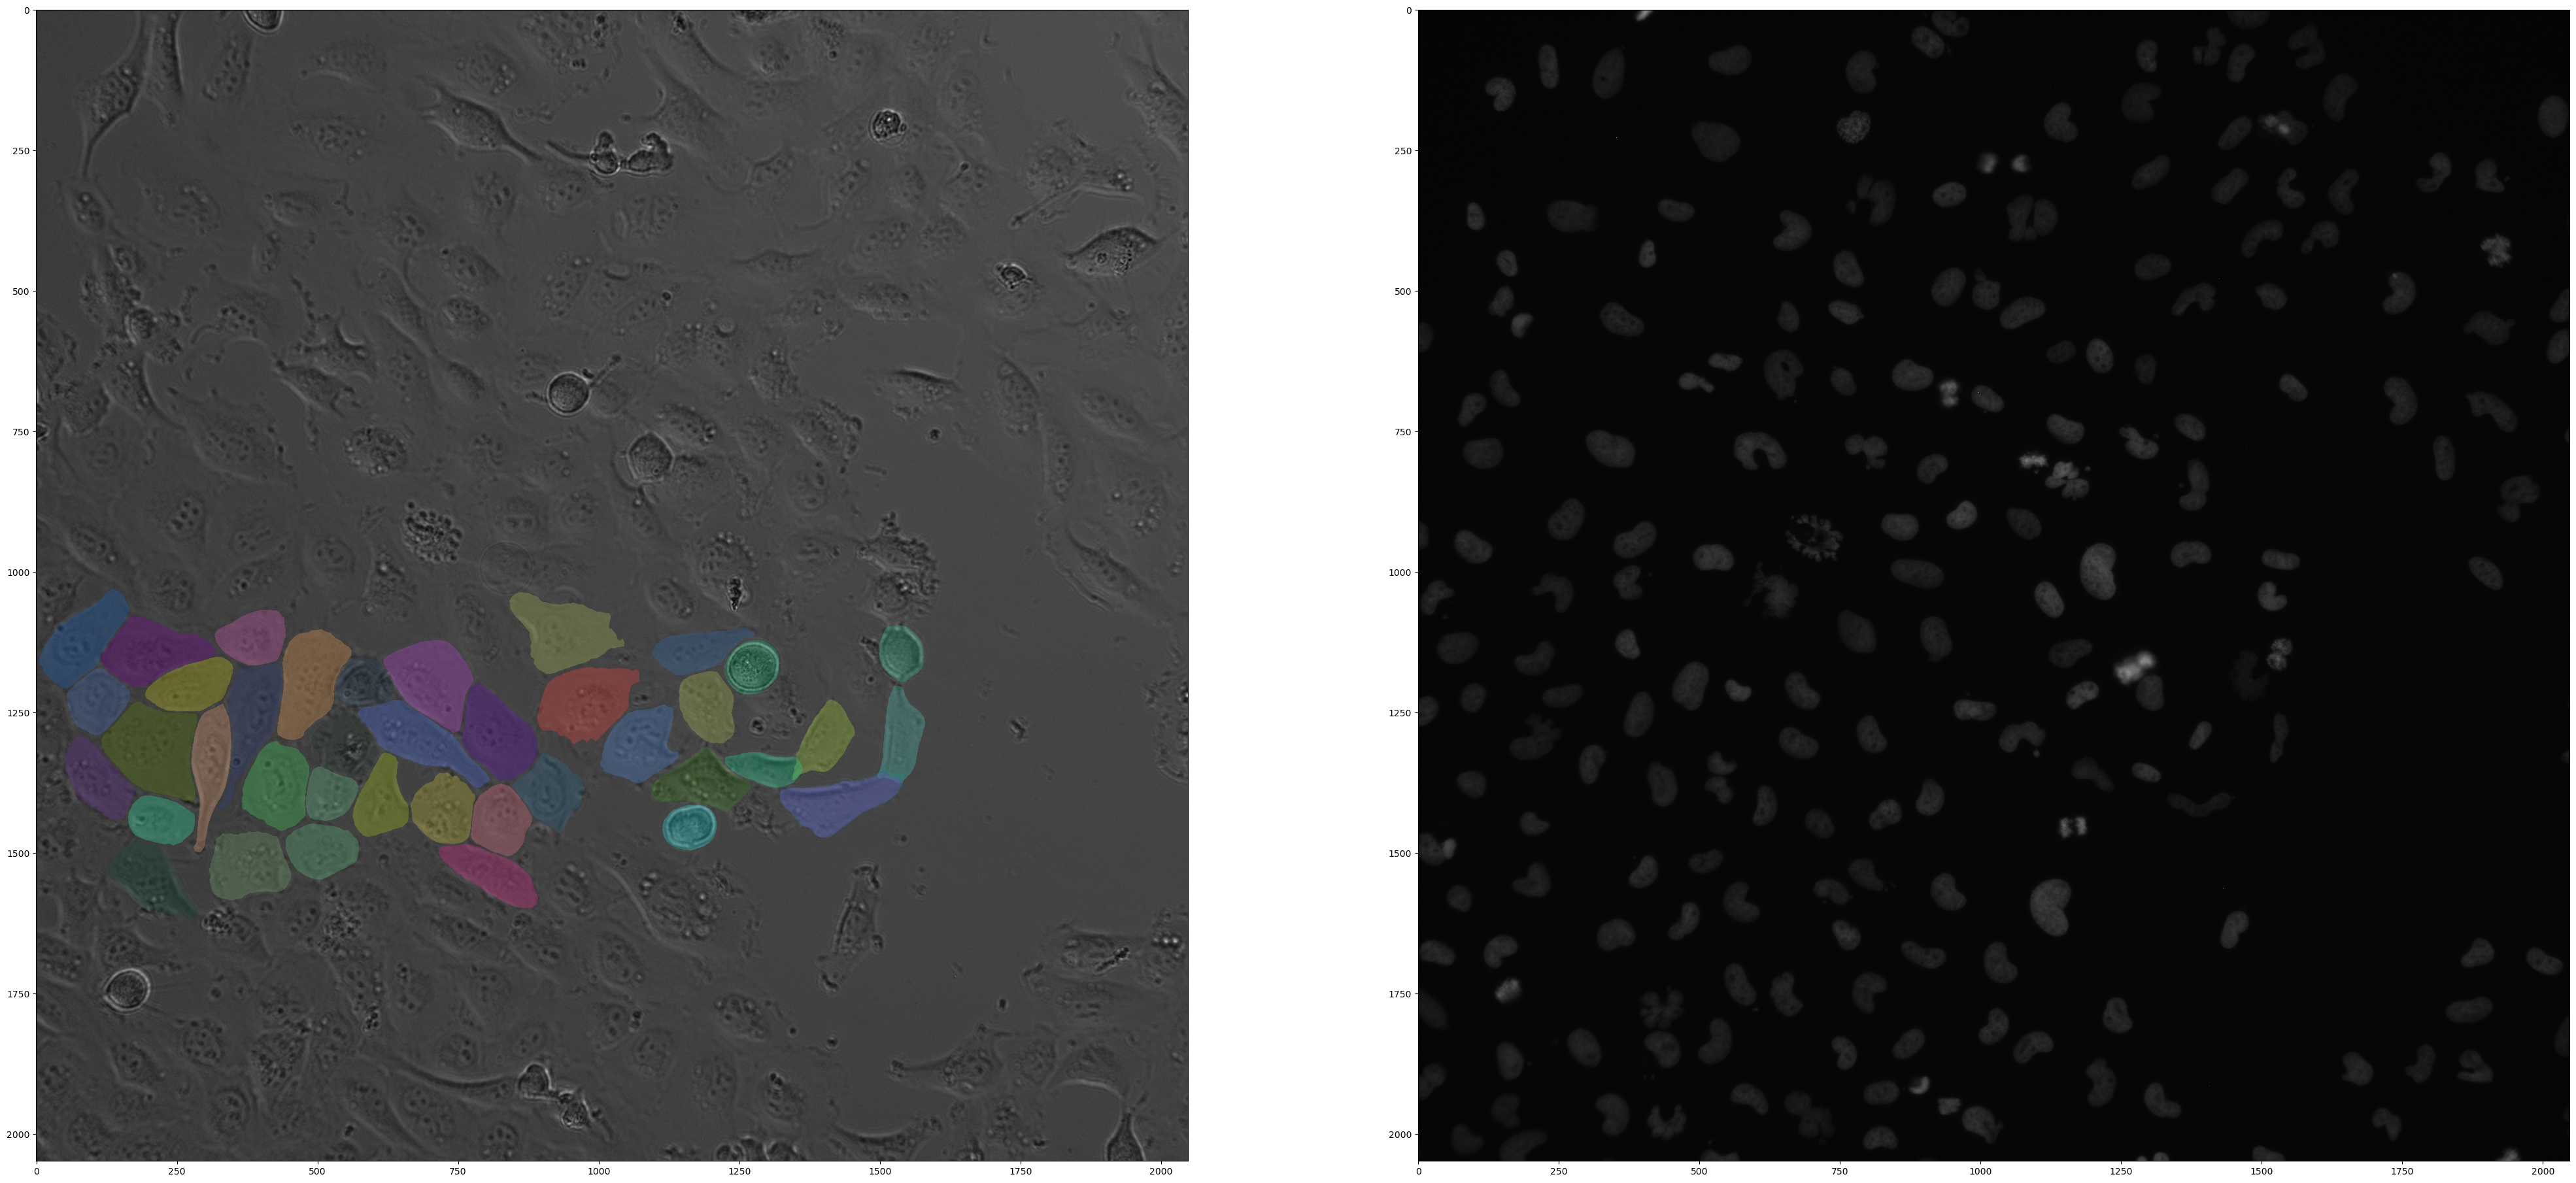

In [22]:
fig, ax = plt.subplots(ncols = 2, figsize = (50,50))

ax[0].imshow(au.bw_to_rgb(instance_whole.phase_image_stack[22]))
ax[1].imshow(au.bw_to_rgb(instance_whole.dna_image_stack[22]))

for i in range(40):
    i+=100
    mask = np.unpackbits(instance_whole.segmentations[22][i], axis = 0, count = 2048)
    mask = np.array([mask]).astype('uint8')
    show_mask(mask, ax[0], random_color = True)

plt.show()

In [8]:
df_unmarked = df_whole[:, :-2]
df_mapper = umap.UMAP(n_neighbors=7,#5
                   min_dist=0,
                   n_components=2,
                   random_state=40).fit(df_unmarked)

df_embedding = df_mapper.fit_transform(df_unmarked)

/home/anishjv/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [47]:
labels_whole_embedding = hdbscan.HDBSCAN(min_samples=3,
                                        min_cluster_size = 350,#200
                                        ).fit_predict(df_embedding)

df_whole_labeled = au.add_labels(df_whole, labels_whole_embedding)

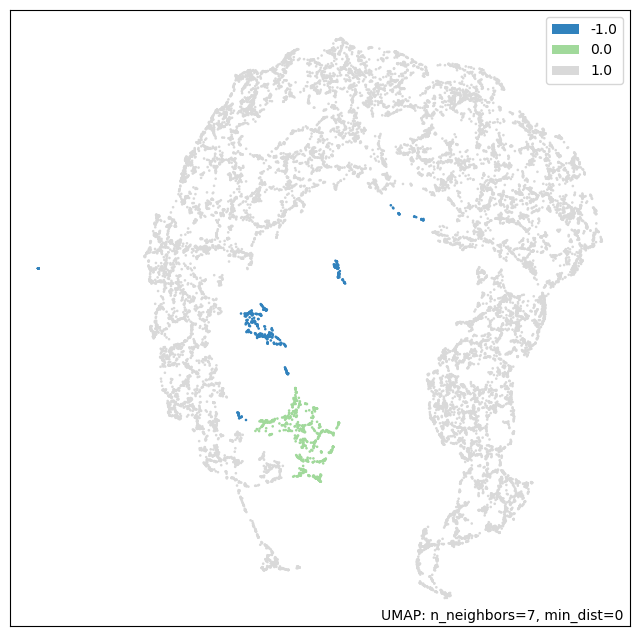

In [48]:
fig = umap.plot.points(df_mapper, labels = df_whole_labeled[:, -1], theme = 'green').get_figure()

In [49]:
clusters = au.write_clusters(df_whole_labeled, -1)
for cluster in clusters.values():
    print(cluster.shape)

(642, 2)
(16493, 2)
(496, 2)


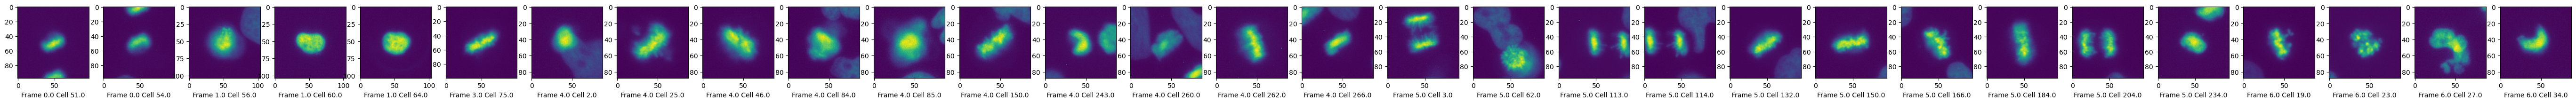

In [50]:
fig, ax = plt.subplots(ncols = 30, figsize = (70,70))

clus = 0
for i in range(30):
    ax[i].imshow(instance_whole.roi[int(clusters[clus][i, 0])][int(clusters[clus][i, 1])])
    ax[i].set_xlabel(f'Frame {clusters[clus][i, 0]} Cell {clusters[clus][i, 1]}')

plt.show()

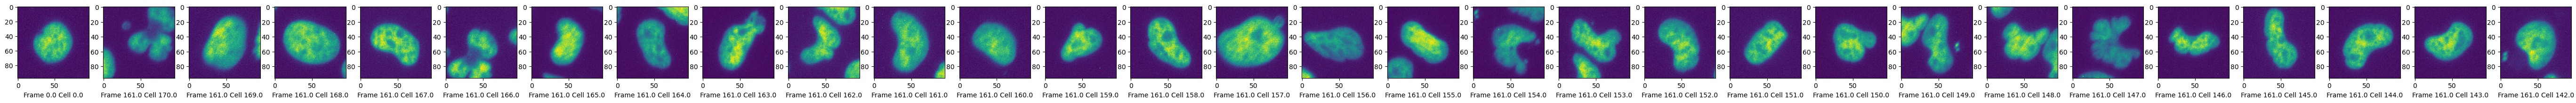

In [51]:
fig, ax = plt.subplots(ncols = 30, figsize = (70,70))

clus = 1
for i in range(30):
    ax[i].imshow(instance_whole.roi[int(clusters[clus][-i, 0])][int(clusters[clus][-i, 1])])
    ax[i].set_xlabel(f'Frame {clusters[clus][-i, 0]} Cell {clusters[clus][-i, 1]}')

plt.show()

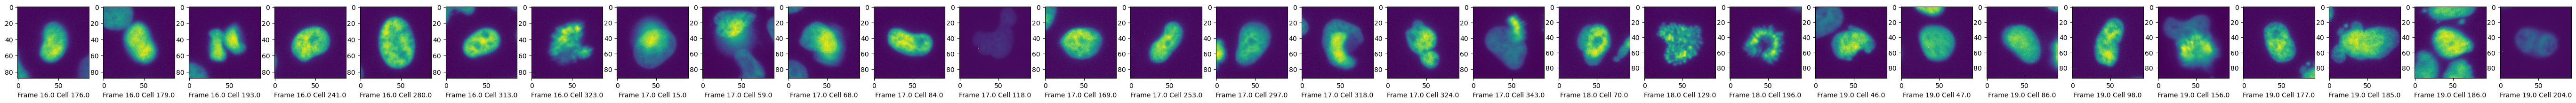

In [86]:
fig, ax = plt.subplots(ncols = 30, figsize = (70,70))

clus = 'noise'
for i in range(30):
    j = i+60
    ax[i].imshow(instance_whole.roi[int(clusters[clus][j, 0])][int(clusters[clus][j, 1])])
    ax[i].set_xlabel(f'Frame {clusters[clus][j, 0]} Cell {clusters[clus][j, 1]}')

plt.show()

In [87]:
for i in range(df_whole_labeled.shape[0]):
    if df_whole_labeled[i, -1] in [0]:
        df_whole_labeled[i, -1] = 1 #mitotic
    else:
        df_whole_labeled[i, -1] = 0 #non-mitotic

In [89]:
phase_image_stack = instance_whole.phase_image_stack
segmentations = instance_whole.segmentations

splits = [
    (0, 116),
    (117, 161)
] #Breaks the dataset into testing and validation subsets by index of the phase_image_stack. In other words,
  # we split the dataset into subsets by image. You can have as many subsets as you desire. 

dw.write_dataset_ranges(
    '/home/anishjv/cell_seg_classify/',
    phase_image_stack,
    segmentations,
    df_whole_labeled,
    splits,
    'HT1080_0.1',
    {0: 'nonmitotic', 1: 'mitotic'} #Dictionary mapping label in the dataset to category name
)